<a href="https://colab.research.google.com/github/effepivi/CIL-DTHE-Reader/blob/main/code/step-wedge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#  Copyright 2024 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal & Nalin Gupta (UKRI-STFC)

# CT scan acquisition simulation using [gVXR](https://gvirtualxray.sourceforge.io/) and CT reconstruction with [CIL](https://ccpi.ac.uk/cil/)

This example makes use of two open source libraries fro X-ray imaging. The first one is [gVXR](https://gvirtualxray.sourceforge.io/). It is used to simulate realistic radiographic images from a step_wedge phantom. The second one is [CIL](https://ccpi.ac.uk/cil/). It implements many CT reconstruction algorithms, including the well-known FDK. The details of the CT scan acquisition are given in the table below. Both FDK and SIRT (iterative method) reconstructions were performed.

![Image comparison of the FDK and SIRT reconstructions](https://github.com/TomographicImaging/gVXR-SPIE2024/blob/main/results/step_wedge/comparison.png?raw=1)

| Parameter | Value |
|-----------|-------|
| source-to-object distance (SOD) | 80 cm |
| object-to-detector distance (ODD) | 80 cm |
| source-to-detector distance (SDD) | 160 cm |
| detector resolution | 512 &times; 512 pixels |
| pixel pitch | 500 &times; 500 &mu;m |
| scintillator | 500 &mu;m of CsI|
| energy response of the detector | ![Plot of the energy response of the detector](https://github.com/TomographicImaging/gVXR-SPIE2024/blob/main/results/step_wedge/detector-energy_response.png?raw=1) |
| detector impulse response | ![Plot of the detector impulse response](https://github.com/TomographicImaging/gVXR-SPIE2024/blob/main/results/step_wedge/detector-LSF.png?raw=1) |
| tube anode material | tungsten |
| tube anode angle | 10&deg; |
| tube voltage | 350 kV |
| beam filtration | 1mm of Sn |
| tube exposure | 0.5 mAs |
| beam spectrum | ![Plot of the beam spectrum](https://github.com/TomographicImaging/gVXR-SPIE2024/blob/main/results/step_wedge/beam-spectrum.png?raw=1) |
| sample geometry | ![](https://github.com/TomographicImaging/gVXR-SPIE2024/blob/main/results/step_wedge/wireframe.png?raw=1) |
| sample material composition | Gold |
| number of projection | 200 |
| first angle | 0&deg; |
| last angle | 360&deg; |
| number of flat images | 60 |

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("Running in Google Colab:", IN_COLAB)

if IN_COLAB:
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    !pip install gvxr xpecgen
    !conda install -q -y -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=24.1.0 SimpleITK tigre astra-toolbox=*=cuda* k3d pillow

Running in Google Colab: True
✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
 - https://software.repos.intel.com/python/conda
 - ccpi
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - astra-toolbox[build=cuda*]
    - cil=24.1.0
    - k3d
    - pillow
    - simpleitk
    - tigre


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.12            |       h4ab18f5_0         543 KB  conda-forge
    aom-3.9.1                  |       hac33072_0         2.6 MB  conda-forge
    astra-toolbox-2.1.0        |cudapy310h7f18647_105         414 KB  conda-forge
    asttokens-2.4.1            |     pyhd8ed1ab_0          28 KB  conda-forge
    attr-2.5.1                 |       h166bdaf_1          69 KB  conda-forge
    blosc-1.21.5               |       hc2324a3_1          48 KB  conda-forge
   

In [3]:
# Import packages
import os, time
import numpy as np
import SimpleITK as sitk

# Increase the font size in plots
import matplotlib
font = {'weight' : 'bold',
        'size'   : 25}

matplotlib.rc('font', **font)

import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm

from gvxrPython3 import gvxr # Simulate X-ray images
from gvxrPython3.utils import has_spekpy, loadSpectrumSpekpy, loadSpectrumXpecgen
from gvxrPython3.utils import visualise # 3D visualisation in a Jupyter notebook

import ipywidgets as widgets
import IPython.display
import PIL.Image

# CT reconstruction using CIL
from cil.io import TIFFStackReader, TIFFWriter
from cil.utilities.display import show2D, show_geometry
from cil.processors import TransmissionAbsorptionConverter
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.recon import FDK
from cil.optimisation.algorithms import SIRT
from cil.optimisation.functions import IndicatorBox
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.jupyter import islicer

spekpy is not install, you won't be able to load a beam spectrum using spekpy


In [4]:
if not os.path.exists("../results"):
    os.mkdir("../results")

if not os.path.exists("../results/step_wedge"):
    os.mkdir("../results/step_wedge")

In [5]:
def getRuntime(start, stop):
    return stop - start, "sec";

## Set the simulation parameters

In [6]:
# Create an OpenGL context
print("Create an OpenGL context")
gvxr.createOpenGLContext();

Create an OpenGL context


In [7]:
# Set up the detector
print("Set up the detector");
gvxr.setDetectorPosition(0.0, 80.0, 0.0, "cm");
gvxr.setDetectorUpVector(0, 0, -1);
gvxr.setDetectorNumberOfPixels(512, 512);
gvxr.setDetectorPixelSize(500, 500, "um");

# Set the impulse response of the detector, a convolution kernel
gvxr.setLSF([0.00110698, 0.00122599, 0.00136522, 0.00152954, 0.00172533, 0.00196116, 0.0022487, 0.00260419, 0.00305074, 0.00362216, 0.00436939, 0.00537209, 0.00676012, 0.0087564, 0.01176824, 0.01659933, 0.02499446, 0.04120158, 0.0767488, 0.15911699, 0.24774516, 0.15911699, 0.0767488, 0.04120158, 0.02499446, 0.01659933, 0.01176824, 0.0087564, 0.00676012, 0.00537209, 0.00436939, 0.00362216, 0.00305074, 0.00260419, 0.0022487, 0.00196116, 0.00172533, 0.00152954, 0.00136522, 0.00122599, 0.00110698])

# Set the scintillator
gvxr.setScintillator("CsI", 500, "um");

Set up the detector


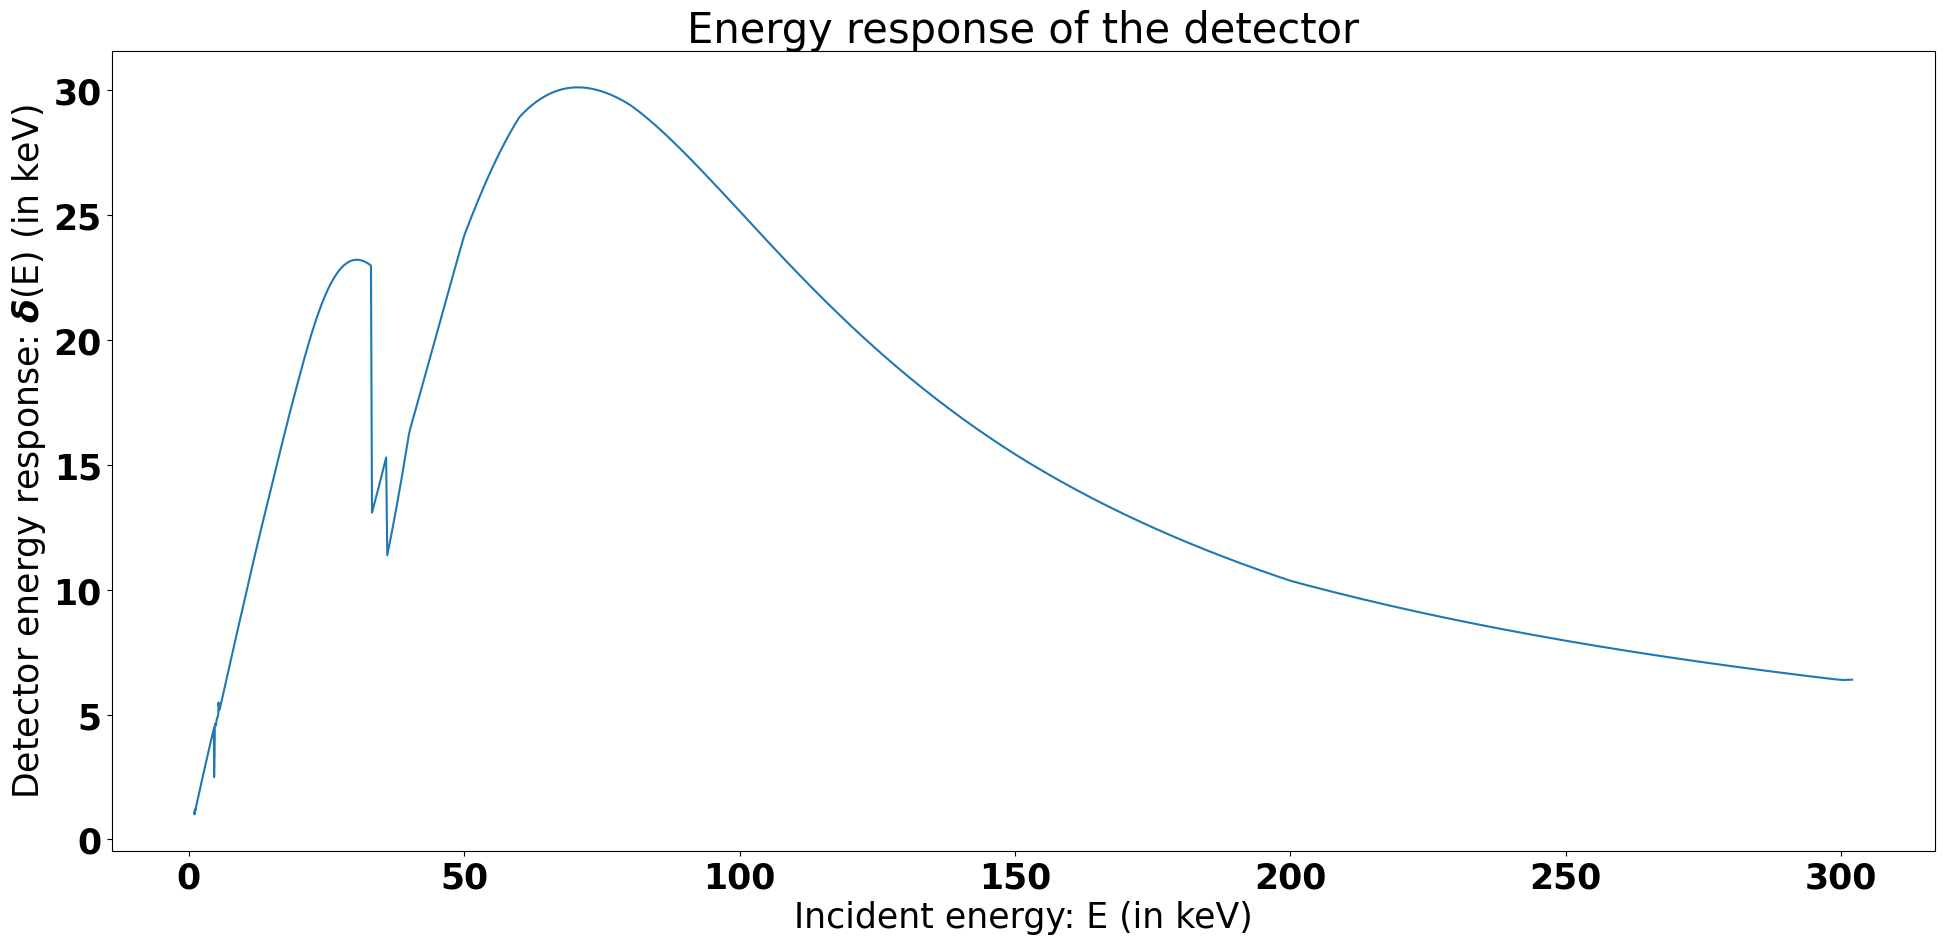

In [8]:
# Plot the energy response of the detector
detector_response = np.array(gvxr.getEnergyResponse("keV"))
plt.figure(figsize= (20,10))
plt.title("Energy response of the detector")
plt.plot(detector_response[:,0], detector_response[:,1])
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')
plt.tight_layout()
plt.savefig("../results/step_wedge/detector-energy_response.png", dpi=20)
plt.savefig("../results/step_wedge/detector-energy_response.pdf", dpi=600)

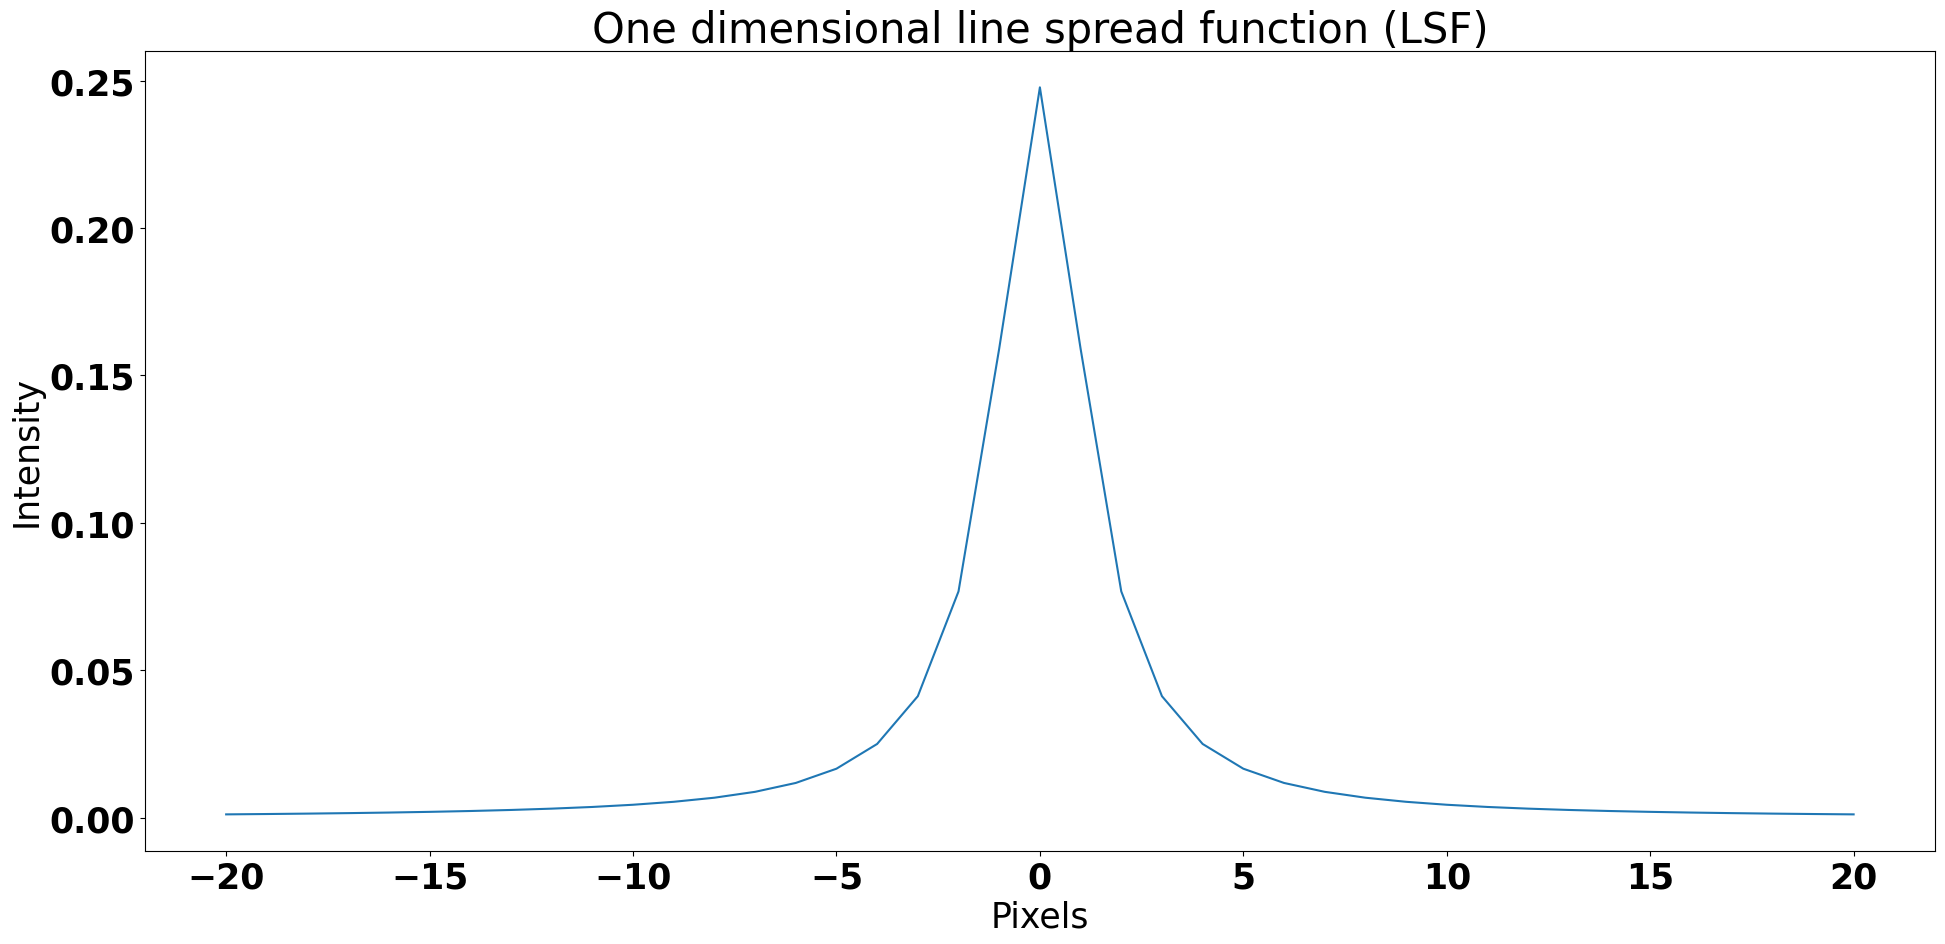

In [9]:
# Plot the energy response of the detector
lsf = np.array(gvxr.getLSF())
half_size = len(lsf) // 2
x = np.arange(-half_size, half_size + 1)

plt.figure(figsize= (20,10))
plt.title("One dimensional line spread function (LSF)")
plt.plot(x, lsf)
plt.xlabel('Pixels')
plt.ylabel('Intensity')
plt.tight_layout()
plt.savefig("../results/step_wedge/detector-LSF.png", dpi=20)
plt.savefig("../results/step_wedge/detector-LSF.pdf", dpi=600)

In [10]:
# Create a source
print("Set up the beam")
gvxr.setSourcePosition(0.0,  -80.0, 0.0, "cm");
gvxr.usePointSource();
#  For a parallel source, use gvxr.useParallelBeam();

# Set its spectrum, here a monochromatic beam
# 1000 photons of 80 keV (i.e. 0.08 MeV) per ray
# gvxr.setMonoChromatic(0.08, "MeV", 1000);
# The following is equivalent: gvxr.setMonoChromatic(80, "keV", 1000);

# Or use a polychromatic beam
# The tube voltage is 160 keV
# The filtration is 1mm of tin (Sn)
# The anode angle is 12 degrees
# mAs is 0,5
# The source to detector distance in 50 cm

if has_spekpy:
    loadSpectrumSpekpy(350, filters=[["Sn", 1.0]], th_in_deg=12, mAs=0.5, z=150 - -40);

    # Poisson noise will be enable
    gvxr.enablePoissonNoise(); # Not needed as mAs was used in the function call above
else:
    loadSpectrumXpecgen(350, filters=[["Sn", 1.0]], th_in_deg=12);



Set up the beam


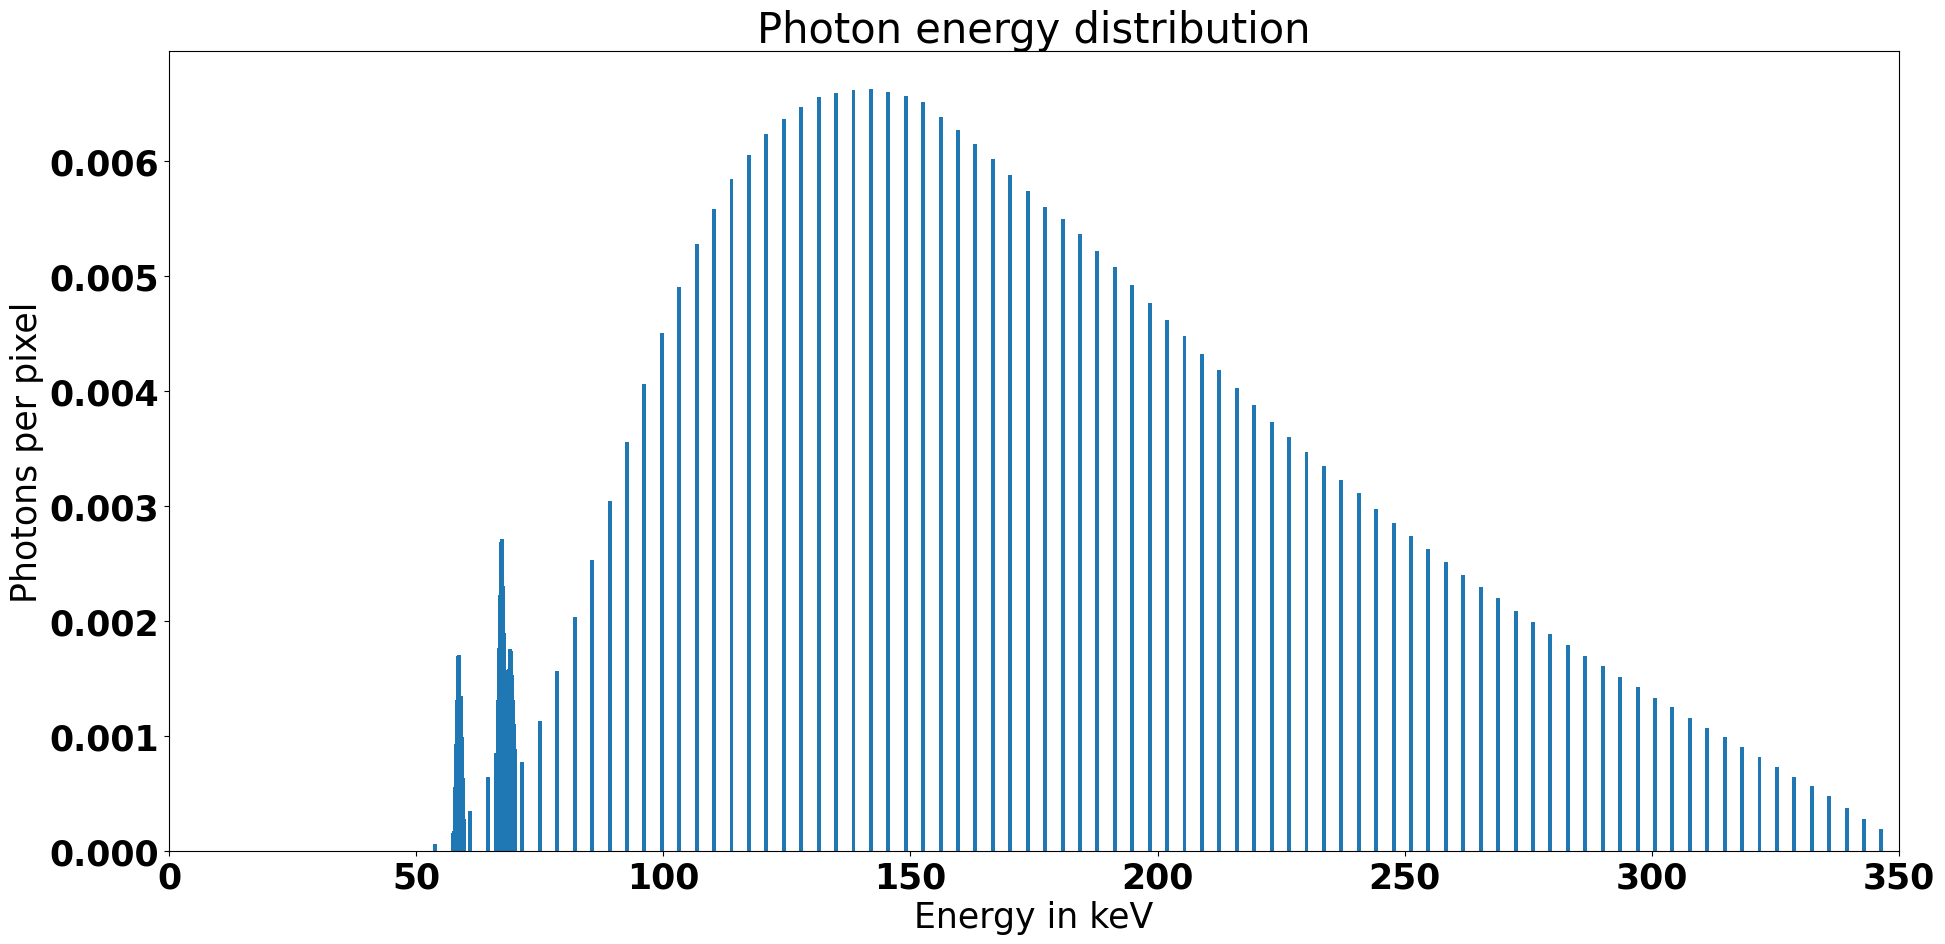

In [11]:
# Plot the beam spectrum
energy_bins = gvxr.getEnergyBins("keV")
photon_counts = gvxr.getPhotonCountEnergyBins()
plt.figure(figsize=(20,10))
plt.bar(energy_bins, photon_counts)
plt.xlabel('Energy in keV')
plt.ylabel('Photons per pixel')
plt.title('Photon energy distribution')
plt.xlim([0,350])
plt.tight_layout()

plt.savefig("../results/step_wedge/beam-spectrum.png", dpi=20)
plt.savefig("../results/step_wedge/beam-spectrum.pdf", dpi=600)

In [12]:
def value_changed(change):
    output.value = change
    print(change)

unit_widget = widgets.Dropdown(
    options=['um', 'mm', 'cm'],
    value='mm',
    description='Unit:',
    disabled=False,
    callback=value_changed
)

number_of_steps_widget = widgets.IntSlider(
    value=7,
    min=2,
    max=10,
    step=1,
    description='Steps:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

length_widget = widgets.FloatSlider(
    value=50.0,
    min=0,
    max=100.0,
    step=0.1,
    description='Length:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

width_widget = widgets.FloatSlider(
    value=10.0,
    min=0,
    max=50.0,
    step=0.1,
    description='Width:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

first_step_height_widget = widgets.FloatSlider(
    value=10.0,
    min=0,
    max=50.0,
    step=0.1,
    description='Height of 1st step:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

other_step_height_widget = widgets.FloatSlider(
    value=5.0,
    min=0,
    max=50.0,
    step=0.1,
    description='Height of other steps:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

wireframe_widget = widgets.Checkbox(
    value=False,
    description='Wireframe',
    disabled=False
)

button = widgets.Button(description="Apply")
output = widgets.Output()
widget_set = [unit_widget, number_of_steps_widget, length_widget, width_widget, first_step_height_widget, other_step_height_widget, button, wireframe_widget, output]

def on_button_clicked(b):
    with output:
        gvxr.removePolygonMeshesFromSceneGraph()
        gvxr.makeStepWedge("Step wedge",
                number_of_steps_widget.value,
                length_widget.value,
                width_widget.value,
                first_step_height_widget.value,
                other_step_height_widget.value,
                unit_widget.value);
        gvxr.addPolygonMeshAsInnerSurface("Step wedge")

        gvxr.setNodeTransformationMatrix("Step wedge", [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]);
        gvxr.rotateNode("Step wedge", 90, 1, 0, 0)

        red = 255 / 255
        green = 215 / 255
        blue = 0 / 255
        gvxr.setColour("Step wedge", red, green, blue, 1.0)

        gvxr.setElement("Step wedge", "Au");
        gvxr.useWireframe(wireframe_widget.value)
        gvxr.computeXRayImage();
        gvxr.displayScene();

        with output:
            output.clear_output()

            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.imshow(gvxr.takeScreenshot())
            plt.axis('off');
            plt.show()
    pass

def wireframeCallback(b):
    gvxr.useWireframe(wireframe_widget.value)
    gvxr.displayScene();

    with output:
        output.clear_output()
        screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)
        IPython.display.display(PIL.Image.fromarray(screenshot))
    pass


button.on_click(on_button_clicked)
wireframe_widget.observe(wireframeCallback, 'value')

display(*widget_set)

on_button_clicked(None)

with output:
    gvxr.displayBeam(False)
    gvxr.setZoom(200);
    gvxr.useWireframe(wireframe_widget.value)
    gvxr.displayScene();
    output.clear_output()
    screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)
    IPython.display.display(PIL.Image.fromarray(screenshot))

Dropdown(description='Unit:', index=1, options=('um', 'mm', 'cm'), value='mm')

IntSlider(value=7, continuous_update=False, description='Steps:', max=10, min=2)

FloatSlider(value=50.0, continuous_update=False, description='Length:', readout_format='.1f')

FloatSlider(value=10.0, continuous_update=False, description='Width:', max=50.0, readout_format='.1f')

FloatSlider(value=10.0, continuous_update=False, description='Height of 1st step:', max=50.0, readout_format='…

FloatSlider(value=5.0, continuous_update=False, description='Height of other steps:', max=50.0, readout_format…

Button(description='Apply', style=ButtonStyle())

Checkbox(value=False, description='Wireframe')

Output()

In [13]:
gvxr.saveSTLfile("Step wedge", os.path.join("../results/step_wedge", "step_wedge.stl"))

In [14]:
# Compute an X-ray image
x_ray_image = np.array(gvxr.computeXRayImage()).astype(np.single) / gvxr.getWhiteImage()

In [15]:
if IN_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

# Use k3d to perform the 3D visualisation
plot = visualise()
plot.display()

Output()

In [16]:
# Save the plot in an HTML file
if plot:
    with open('../results/step_wedge/snapshot.html','w') as fp:
        fp.write(plot.get_snapshot())

if IN_COLAB:
    output.disable_custom_widget_manager()

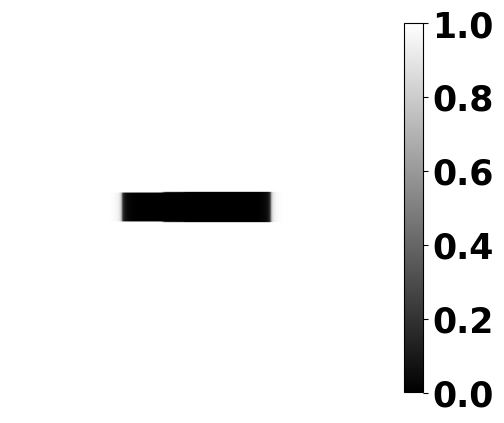

In [17]:
# Display the corresponding X-ray image
plt.imshow(x_ray_image, cmap="gray");
plt.colorbar()
plt.axis('off');

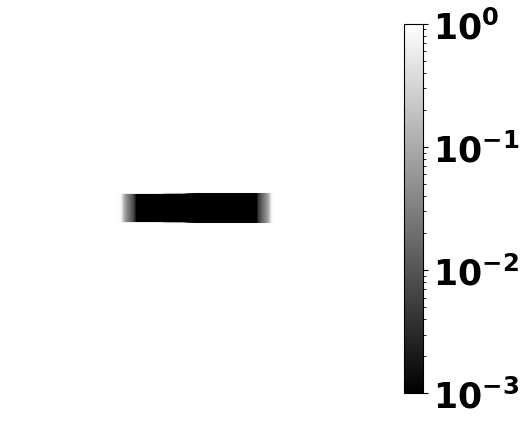

In [18]:
# Display the corresponding X-ray image
plt.imshow(x_ray_image, cmap="gray", norm=LogNorm(vmin=0.001, vmax=1));
plt.colorbar()
plt.axis('off');

In [19]:
# Change to a white background (it could be useful for putting screenshots in papers)
gvxr.setWindowBackGroundColour(1.0, 1.0, 1.0, -1);

In [20]:
# Interactive visualisation
# The user can rotate the 3D scene and zoom-in and -out in the visualisation window.
# It can be useful to rotate the visualisation of the 3D environment and zoom in/out
# to take the best posible screenshots

# - Keys are:
#     - Q/Escape: to quit the event loop (does not close the window)
#     - B: display/hide the X-ray beam
#     - W: display the polygon meshes in solid or wireframe
#     - N: display the X-ray image in negative or positive
#     - H: display/hide the X-ray detector
# - Mouse interactions:
#     - Zoom in/out: mouse wheel
#     - Rotation: Right mouse button down + move cursor```
# gvxr.renderLoop()

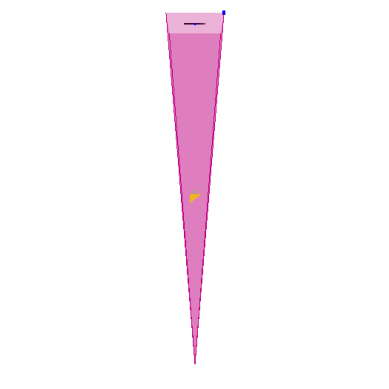

In [21]:
# Take and display a screenshot
gvxr.setZoom(2100);
gvxr.displayBeam(True)
gvxr.displayScene();
screenshot = gvxr.takeScreenshot();
plt.imshow(screenshot);
plt.axis('off');

## Simulate the CT acquisition and save the projections

In [22]:
start = time.time();

# Simulate a CT scan acquisition
gvxr.computeCTAcquisition("../results/step_wedge/projs", # Where to save the projections
                          "screenshots", # Where to save the screenshots
                          200, # Total number of projections
                          0, # First angle
                          True, # Include the last angle
                          360, # Last angle
                          60, # Number of flat images
                          0, 0, 0, "mm", # Centre of rotation
                          *gvxr.getDetectorUpVector()); # Rotation axis

stop = time.time();
runtime, unit = getRuntime(start, stop);
print("Total execution time:", "{0:0.2f}".format(runtime), unit);
print("Execution time per projection:", "{0:0.2f}".format(runtime / gvxr.getNumberOfProjectionsCT()), unit);

Total execution time: 333.26 sec
Execution time per projection: 1.67 sec


## Set the CT reconstruction parameters

In [23]:
# Create the TIFF reader by passing the directory containing the files
reader = TIFFStackReader(file_name="../results/step_wedge/projs", dtype=np.float32)

# Read in file, and return a numpy array containing the data
data_original = reader.read()

# The data is stored as a stack of detector images, we use the CILlabels for the axes
axis_labels = ['angle','vertical','horizontal']

In [24]:
# Update the font size
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

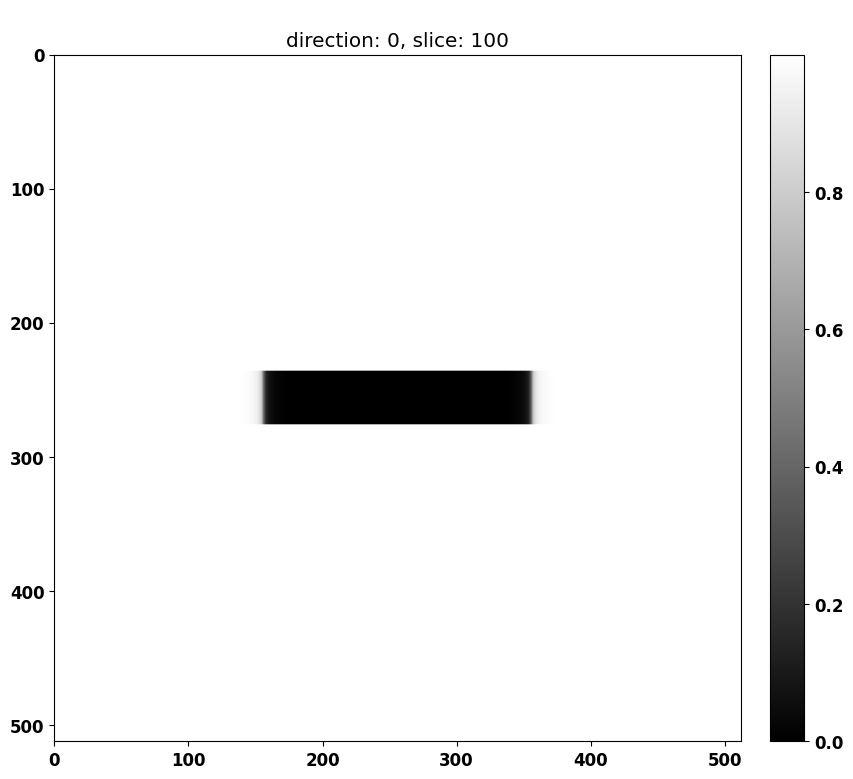

In [25]:
# Use show2D to visualise a projection
show2D(data_original, origin="upper-left")

In [26]:
# Interactive visualisation in Jupyter
islicer(data_original, origin="upper-left")

In [27]:
# Normalisation
# Not strictly needed as the data was already corrected
data_normalised = data_original / data_original.max()

# Prevent log of a negative value
data_normalised[data_normalised<1e-9] = 1e-9

# Linearisation
data_absorption = -np.log(data_normalised)

In [28]:
# Create the CIL geoemtry
geometry = AcquisitionGeometry.create_Cone3D(source_position=gvxr.getSourcePosition("cm"),
                                             detector_position=gvxr.getDetectorPosition("cm"),
                                             detector_direction_x=gvxr.getDetectorRightVector(),
                                             detector_direction_y=gvxr.getDetectorUpVector(),
                                             rotation_axis_position=gvxr.getCentreOfRotationPositionCT("cm"),
                                             rotation_axis_direction=gvxr.getRotationAxisCT())

# Set the angles, remembering to specify the units
geometry.set_angles(np.array(gvxr.getAngleSetCT()), angle_unit='degree')

# Set the detector shape and size
geometry.set_panel(gvxr.getDetectorNumberOfPixels(), gvxr.getDetectorPixelSpacing("cm"))

# Set the order of the data
geometry.set_labels(axis_labels)

# Set the angles, remembering to specify the units
geometry.set_angles(np.array(gvxr.getAngleSetCT()), angle_unit='degree')

# Set the detector shape and size
geometry.set_panel(gvxr.getDetectorNumberOfPixels(), gvxr.getDetectorPixelSpacing("cm"))

In [29]:
# Shutdown the simulation engine
gvxr.terminate()

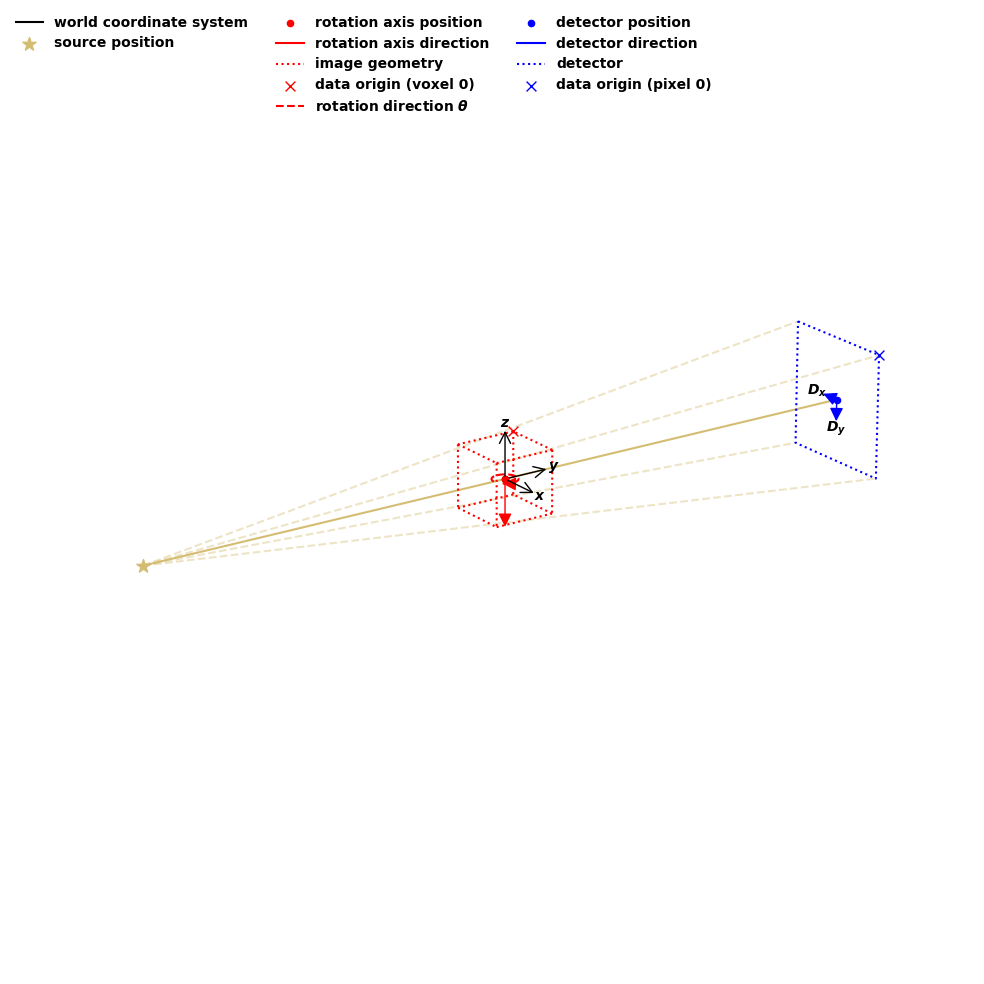

Saved image as /results/step_wedge/geometry.png
Saved image as /results/step_wedge/geometry.pdf


<Figure size 640x480 with 0 Axes>

In [30]:
# Display and save the geometry, does it look like a feasible CT scan set up?
fig = show_geometry(geometry);
fig.save("../results/step_wedge/geometry.png");
fig.save("../results/step_wedge/geometry.pdf");


In [31]:
# Print details of the scanning geometry
print(geometry)

3D Cone-beam tomography
System configuration:
	Source position: [  0., -80.,   0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [ 0.,  0., -1.]
	Detector position: [ 0., 80.,  0.]
	Detector direction x: [-1.,  0.,  0.]
	Detector direction y: [ 0.,  0., -1.]
Panel configuration:
	Number of pixels: [512 512]
	Pixel size: [0.05 0.05]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 200
	Angles 0-9 in degrees: [ 0.       ,  1.8      ,  3.6      ,  5.3999996,  7.2      ,  9.       ,
 10.799999 , 12.599999 , 14.4      , 16.199999 ]
	Angles 190-199 in degrees: [342.     , 343.8    , 345.59998, 347.4    , 349.19998, 351.     ,
 352.8    , 354.59998, 356.4    , 358.19998]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


In [32]:
# Prepare the data for the reconstruction
acquisition_data = AcquisitionData(data_absorption, deep_copy=False, geometry=geometry)
acquisition_data.reorder(order='tigre')
ig = acquisition_data.geometry.get_ImageGeometry()

In [33]:
# Print details of the reconstructed volume
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x512,y512,z512
voxel_size : x0.025,y0.025,z0.025
center : x0,y0,z0



## Perform the CT reconstruction using the FDK algorithm and save the reconstructed volume

In [34]:
# Perform the FDK reconstruction
fdk =  FDK(acquisition_data, ig)
recon = fdk.run()

FDK recon

Input Data:
	angle: 200
	vertical: 512
	horizontal: 512

Reconstruction Volume:
	vertical: 512
	horizontal_y: 512
	horizontal_x: 512

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 10
	Filter_inplace: False



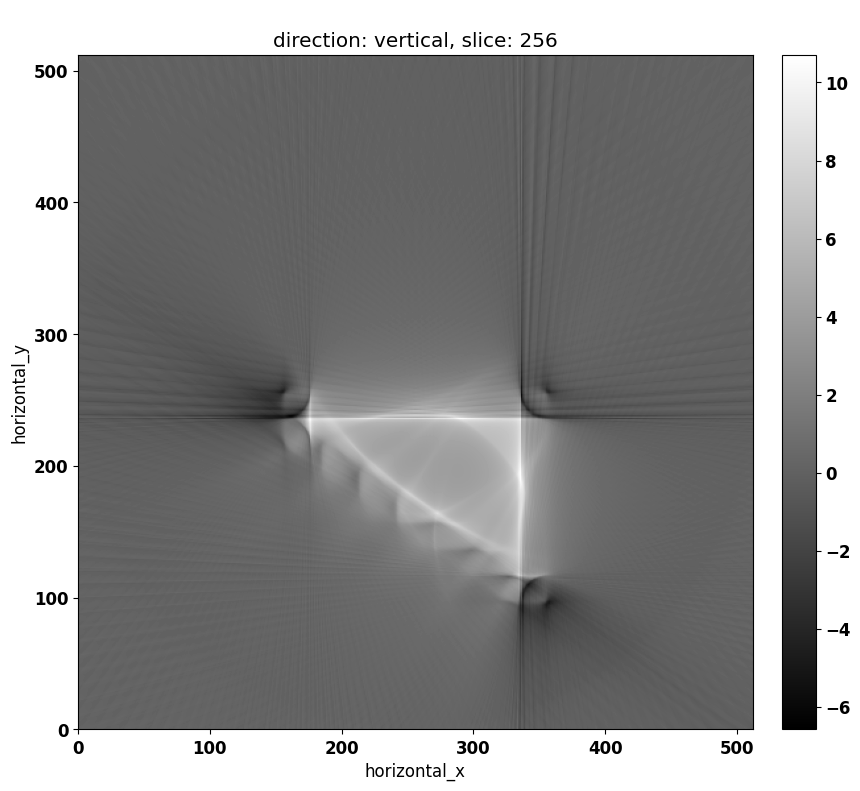

In [35]:
# Show a 2D slice
show2D(recon)

In [36]:
# Interactive visualisation in Jupyter
islicer(recon)

In [37]:
# Save the CT volume as a TIFF stack
TIFFWriter(data=recon, file_name=os.path.join("../results/step_wedge/recons-FDK", "out")).write()

## Perform the CT reconstruction using the SIRT algorithm and save the reconstructed volume

In [38]:
# Create projection operator using Astra-Toolbox.
acquisition_data.reorder(order='astra')
A = ProjectionOperator(ig, geometry, "gpu")

In [39]:
# Create the initial guess
x0 = ig.allocate()

# non-zero constraint
constraint = IndicatorBox(lower=0)

# Instantiate the reconstruction algorithm
sirt = SIRT(initial=x0, operator=A, data=acquisition_data, constraint=constraint, max_iteration=500)

In [40]:
# Perform 500 iterations
sirt.update_objective_interval = 50
sirt.run(500)

recon_sirt_noisy = sirt.solution

  0%|          | 0/500 [00:00<?, ?it/s]

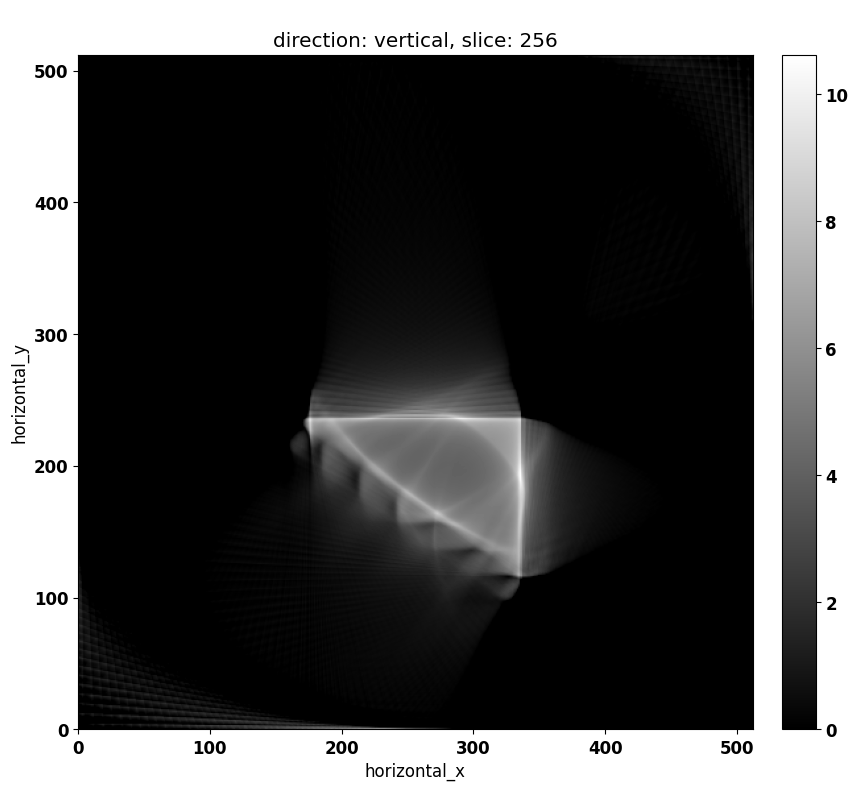

In [41]:
# Show a 2D slice
show2D(recon_sirt_noisy)

In [42]:
# Interactive visualisation in Jupyter
islicer(recon_sirt_noisy)

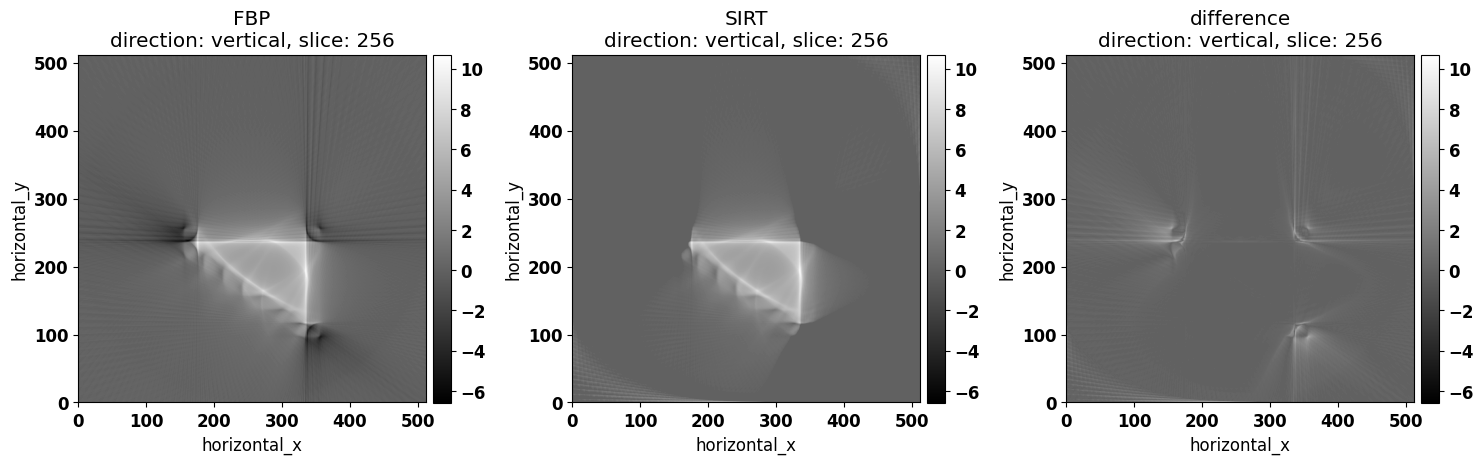

Saved image as /results/step_wedge/comparison.png
Saved image as /results/step_wedge/comparison.pdf


<Figure size 640x480 with 0 Axes>

In [43]:
# Show a comparison
fig = show2D([recon, recon_sirt_noisy, (recon-recon_sirt_noisy).abs()], \
       ['FBP', 'SIRT', 'difference'], \
       cmap="gray", num_cols=3, size=(15,15), origin='bottom-left', fix_range=True);

fig.save("../results/step_wedge/comparison.png", dpi=300)
fig.save("../results/step_wedge/comparison.pdf", dpi=600)

In [44]:
# Save the CT volume as a TIFF stack
TIFFWriter(data=recon_sirt_noisy, file_name=os.path.join("../results/step_wedge/recons-SIRT", "out")).write()